In [49]:
import pandas as pd
import time
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import ydata_profiling as df_report

from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
import seaborn as sns
import plotly.express as px
import matplotlib as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime
import sweetviz as sv
from sklearn.metrics import auc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import kds
from pytz import timezone
from tzfpy import get_tz, get_tzs

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


### Load data from private dataset and public dataset

In [50]:
df_usage = pd.read_csv('data/usage_data_all_features.csv')
display(df_usage.head(2))
df_airtraffic_trends = pd.read_csv('data/Airline_Transportation_Data.csv')
display(df_airtraffic_trends.head(2))

,AIRLINE,TAIL_ID,USAGE_TSTAMP,PREMIUM_PRODUCT,ESI_PRODUCT,TMO_PRODUCT,BASIC_PRODUCT,OTHER_PRODUCT,DOOR_CLOSE_TSTAMP,DOOR_OPEN_PLUS15_TSTAMP,TIME_INTO_FLIGHT,FLIGHT_PHASE,LATITUDE,LONGITUDE,ALTITUDE,TOTAL_FL_MBPS,TOTAL_RL_MBPS,SEAT_CAPACITY,ECO_SEATS
0,DAL,N863DN,2023-05-10T19:00:00Z,1,0,0,0,1,2023-05-10T15:05:57.391Z,2023-05-10T20:20:15.399Z,235.0,10k,36.28,-87.80,36522.25,0.02,0.0,180.0,160.0
1,JBU-R,N3121J,2023-05-10T18:55:00Z,0,1,0,0,1,2023-05-10T16:01:41.626Z,2023-05-10T20:12:55.856Z,174.0,10k,42.18,-78.53,33049.88,0.01,0.0,150.0,108.0


,ID,OBS_DATE,ASM_US_D_I,ASM_D,ASM_I,LOAD_FACTOR_D_PCT_US,LOAD_FACTOR_I_PCT_US
0,SATD200001,1/1/00,76146639.0,56288872.0,19857767.0,62.0,67.2
1,SATD200002,2/1/00,73011377.0,54329819.0,18681558.0,66.3,67.3


### Performing column re-names, EDA,Data Cleaning, Feature Engineering and Feature Selection 

In [52]:

df_airtraffic_trends.rename(columns={'OBS_DATE': 'Month','ASM_US_D_I':'Aggr_seat_miles_domestic_and_international','LOAD_FACTOR_D_PCT_US':'Load_factor_domestic_pct_us'}, inplace=True)
df_airtraffic_trends.drop(['ID','ASM_D','ASM_I','LOAD_FACTOR_I_PCT_US'], axis=1, inplace=True)
df_airtraffic_trends['Month'] = pd.to_datetime(df_airtraffic_trends['Month'])
df_usage.columns = df_usage.columns.str.lower()
df_airtraffic_trends.columns = df_airtraffic_trends.columns.str.lower()
df_usage['usage_tstamp'] = pd.to_datetime(df_usage['usage_tstamp'])
df_usage['door_close_tstamp'] = pd.to_datetime(df_usage['door_close_tstamp'])
df_usage['door_open_plus15_tstamp'] = pd.to_datetime(df_usage['door_open_plus15_tstamp'])

# Based on several iterations of the EDA, it felt like I need to come up with a new feature which is percentage of flight completed 
# and need to find all time related variables in local time than in utc. Used lat,lon to convert time to local timezone.
# Dropped all rows with null vallues for lat,long

df_usage['pct_flight_completed'] = df_usage['time_into_flight']/((df_usage['door_open_plus15_tstamp'] - df_usage['door_close_tstamp']).dt.total_seconds() / 60)
df_usage.drop(['tail_id','door_close_tstamp','door_open_plus15_tstamp'], axis=1, inplace=True)
df_usage.dropna(subset=['latitude','longitude','seat_capacity','eco_seats','airline'],inplace=True)
df_usage['free_model'] = df_usage['airline'].apply(lambda x: 1 if x in ['DAL','JBU','JBU-R','QFA'] else 0)
# The initial data set had a lot of datapoints, so I sampled 1% of the data to do the EDA and build the model
df_usage_sampled = df_usage.sample(frac=0.5, random_state=42,replace=False)

display(df_airtraffic_trends.head(2))
display(df_usage_sampled.head(2))

,month,aggr_seat_miles_domestic_and_international,load_factor_domestic_pct_us
0,2000-01-01,76146639.0,62.0
1,2000-02-01,73011377.0,66.3


,airline,usage_tstamp,premium_product,esi_product,tmo_product,basic_product,other_product,time_into_flight,flight_phase,latitude,longitude,altitude,total_fl_mbps,total_rl_mbps,seat_capacity,eco_seats,pct_flight_completed,free_model
1165305,DAL,2023-05-02 14:45:00+00:00,1,0,0,0,1,71.0,10k,42.52,-81.32,28628.25,13.38,1.27,191.0,118.0,0.606051,1
1589457,DAL,2023-05-04 21:10:00+00:00,1,0,0,0,1,28.0,10k,36.01,-116.07,24660.75,14.94,1.57,157.0,123.0,0.159854,1


In [53]:
# Performing timezone trasnlations to get local time as well as hour of day and day of week

df_usage_sampled['usage_utc_hour'] = df_usage_sampled['usage_tstamp'].dt.hour
df_usage_sampled['usage_month']=df_usage_sampled['usage_tstamp'].dt.month_name()
df_usage_sampled['usage_utc_day']=df_usage_sampled['usage_tstamp'].dt.day_name()

def local_time_mapper(x):
    return get_tz(lat=x['latitude'], lng=x['longitude'])


df_usage_sampled['usage_tz'] = df_usage_sampled.apply(lambda x: local_time_mapper(x), axis=1)

# Throwing away few rows which had no timezone look up, very small numebr of rows
df_usage_sampled = df_usage_sampled[df_usage_sampled['usage_tz']!='']

# Converting utc time to local time based on the timezone and then getting the local hour of the day and day of the week

df_usage_sampled['usage_local_hour'] = df_usage_sampled.apply(lambda row: row['usage_tstamp'].tz_convert(timezone(row['usage_tz'])).hour, axis=1)
df_usage_sampled['usage_local_hour_shifted'] = df_usage_sampled['usage_local_hour'].apply(lambda x: (pd.Timedelta(hours=x) + pd.Timedelta(hours=-3)).components.hours)
df_usage_sampled['usage_local_day'] = df_usage_sampled.apply(lambda row: row['usage_tstamp'].tz_convert(timezone(row['usage_tz'])).strftime("%A"), axis=1)

display(df_usage_sampled.head(2))

,airline,usage_tstamp,premium_product,esi_product,tmo_product,basic_product,other_product,time_into_flight,flight_phase,latitude,...,eco_seats,pct_flight_completed,free_model,usage_utc_hour,usage_month,usage_utc_day,usage_tz,usage_local_hour,usage_local_hour_shifted,usage_local_day
1165305,DAL,2023-05-02 14:45:00+00:00,1,0,0,0,1,71.0,10k,42.52,...,118.0,0.606051,1,14,May,Tuesday,America/Toronto,10,7,Tuesday
1589457,DAL,2023-05-04 21:10:00+00:00,1,0,0,0,1,28.0,10k,36.01,...,123.0,0.159854,1,21,May,Thursday,America/Los_Angeles,14,11,Thursday


In [54]:
# Dropping un-wanted rows before doing one more final round of eda through sweetviz

df_usage_sampled.drop(['usage_tstamp','usage_tz'], axis=1, inplace=True)

df_usage_eda_report = sv.analyze(df_usage_sampled, target_feat='total_fl_mbps')
df_usage_eda_report.show_html('eda-viz/df_usage_per_tail_seatcapacity_eda_report.html')


                                             |          | [  0%]   00:00 -> (? left)

Report eda-viz/df_usage_per_tail_seatcapacity_eda_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [55]:
# Based on the output of the FInal run of eda, dropping unwanted columns as well as columns which are not available at the time of prediction ('total_rl_mbps')
df_usage_sampled.drop(columns=['usage_utc_day','usage_utc_hour','usage_local_hour','usage_month','total_rl_mbps'],inplace=True)
df_usage_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14924 entries, 1165305 to 2205584
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   airline                   14924 non-null  object 
 1   premium_product           14924 non-null  int64  
 2   esi_product               14924 non-null  int64  
 3   tmo_product               14924 non-null  int64  
 4   basic_product             14924 non-null  int64  
 5   other_product             14924 non-null  int64  
 6   time_into_flight          14924 non-null  float64
 7   flight_phase              14924 non-null  object 
 8   latitude                  14924 non-null  float64
 9   longitude                 14924 non-null  float64
 10  altitude                  14924 non-null  float64
 11  total_fl_mbps             14924 non-null  float64
 12  seat_capacity             14924 non-null  float64
 13  eco_seats                 14924 non-null  float64
 14

In [56]:
# Converting local_hour and pct flight completed to categorical variables based on the output of final eda run
df_usage_sampled['usage_local_hour_shifted'] = df_usage_sampled['usage_local_hour_shifted'].astype('str')
df_usage_sampled['pct_flight_completed'] = round((100*df_usage_sampled['pct_flight_completed']/10),0).astype('str')

In [57]:
#throwing outliers in total_fl_mbps which are between 0.1 and  99.5th percentile
df_usage_sampled = df_usage_sampled[ ( df_usage_sampled['total_fl_mbps']<df_usage_sampled['total_fl_mbps'].quantile(0.995)) & (df_usage_sampled['total_fl_mbps']>df_usage_sampled['total_fl_mbps'].quantile(0.001)) ]

In [58]:
# Applying column transformer to encode categorical variables and scale numeric variables

# Get columns of integer or float type
numeric_cols = df_usage_sampled.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)
# Get columns of object type
object_cols = df_usage_sampled.select_dtypes(include=['object']).columns
print(object_cols)

# Categorical feature columns to one-hot encode
categorical_cols = ['airline','flight_phase','usage_local_day','pct_flight_completed','usage_local_hour_shifted','pct_flight_completed']
# Numerical feature columns to standard scale
numerical_cols = ['altitude','seat_capacity','eco_seats']

# Create transformers for one-hot encoding and standard scaling
column_trans = ColumnTransformer(
    transformers=[
        ('ohe',OneHotEncoder(sparse=False), categorical_cols),
        ('std_scaled',StandardScaler(), numerical_cols),
    ],
    remainder='passthrough',
    )
column_trans.set_output(transform='pandas')
transformed_data = column_trans.fit_transform(df_usage_sampled)
df_usage_column_transformed = pd.DataFrame(transformed_data)

df_usage_column_transformed.rename(columns={'remainder__total_fl_mbps':'total_fl_mbps'}, inplace=True)
display(df_usage_column_transformed.head(2))

Index(['premium_product', 'esi_product', 'tmo_product', 'basic_product',
       'other_product', 'time_into_flight', 'latitude', 'longitude',
       'altitude', 'total_fl_mbps', 'seat_capacity', 'eco_seats',
       'free_model'],
      dtype='object')
Index(['airline', 'flight_phase', 'pct_flight_completed',
       'usage_local_hour_shifted', 'usage_local_day'],
      dtype='object')


,ohe__airline_DAL,ohe__flight_phase_10k,ohe__flight_phase_g2g,ohe__flight_phase_wow2wow,ohe__usage_local_day_Friday,ohe__usage_local_day_Monday,ohe__usage_local_day_Saturday,ohe__usage_local_day_Sunday,ohe__usage_local_day_Thursday,ohe__usage_local_day_Tuesday,...,remainder__premium_product,remainder__esi_product,remainder__tmo_product,remainder__basic_product,remainder__other_product,remainder__time_into_flight,remainder__latitude,remainder__longitude,total_fl_mbps,remainder__free_model
1165305,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0,1,71.0,42.52,-81.32,13.38,1
1589457,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0,1,28.0,36.01,-116.07,14.94,1


In [59]:
# X_before_poly = df_usage_column_transformed.drop('total_fl_mbps', axis=1) 
# display(X_before_poly.shape)
# display(X_before_poly.head())
# poly_features = PolynomialFeatures(degree=2)
# X_poly = poly_features.fit_transform(X_before_poly)
# X = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X_before_poly.columns))

# display(X.shape)
# display(X.head())
display(df_usage_column_transformed.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14499 entries, 1165305 to 2205584
Data columns (total 70 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ohe__airline_DAL                  14499 non-null  float64
 1   ohe__flight_phase_10k             14499 non-null  float64
 2   ohe__flight_phase_g2g             14499 non-null  float64
 3   ohe__flight_phase_wow2wow         14499 non-null  float64
 4   ohe__usage_local_day_Friday       14499 non-null  float64
 5   ohe__usage_local_day_Monday       14499 non-null  float64
 6   ohe__usage_local_day_Saturday     14499 non-null  float64
 7   ohe__usage_local_day_Sunday       14499 non-null  float64
 8   ohe__usage_local_day_Thursday     14499 non-null  float64
 9   ohe__usage_local_day_Tuesday      14499 non-null  float64
 10  ohe__usage_local_day_Wednesday    14499 non-null  float64
 11  ohe__pct_flight_completed_0.0     14499 non-null  float64
 

None

In [60]:
# Split the df into train test split with 80:20 ratio 

X = df_usage_column_transformed.loc[:, df_usage_column_transformed.columns != 'total_fl_mbps']
y = df_usage_column_transformed['total_fl_mbps']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining a set of regression models to be used for hyper parameter tuning

regressors = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(fit_intercept=False), {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}),
    'Lasso Regression': (Lasso(), {'alpha': [0.00001,0.0001,0.001,0.01, 0.1, 1.0, 10.0, 100.0]}),
    'Random Forest Regressor': (RandomForestRegressor(n_jobs=-1), {'n_estimators': [ 50, 100, 200], 'max_depth': [5, 7, 10, 15, 20, 40]}),
    #'Support Vector Regressor': (SVR(), {'C': [1, 10], 'kernel': ['linear', 'rbf']})
}

best_models = []
# Perform grid search for each regressor
for regressor_name, (regressor, param_grid) in regressors.items():
    grid_search = GridSearchCV(regressor, param_grid, scoring='r2', cv=5, verbose=2)
    grid_search.fit(X_train, y_train)

    # Get the best estimator and make predictions
    best_regressor = grid_search.best_estimator_
    y_pred = best_regressor.predict(X_test)

    # Calculate and print the R2 score

    r2 = r2_score(y_test, y_pred)
    print(f"{regressor_name}: Best Parameters: {grid_search.best_params_}, R2 Score: {r2}")
    best_models.append({'regressor':regressor_name,'model':best_regressor})


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
Linear Regression: Best Parameters: {}, R2 Score: 0.33783898286255243
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+04, tolerance: 7.208e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   0.5s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.288e+04, tolerance: 7.255e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   0.5s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+04, tolerance: 7.183e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.218e+03, tolerance: 7.297e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.318e+04, tolerance: 7.214e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.409e+03, tolerance: 7.208e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   0.5s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e+03, tolerance: 7.255e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+03, tolerance: 7.183e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e+03, tolerance: 7.297e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e+04, tolerance: 7.214e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e+03, tolerance: 7.208e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e+03, tolerance: 7.255e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e+03, tolerance: 7.183e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time=   0.5s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.606e+03, tolerance: 7.297e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+03, tolerance: 7.214e+01
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time=   0.4s
[CV] END .........................................alpha=0.01; total time=   0.1s
[CV] END .........................................alpha=0.01; total time=   0.1s
[CV] END .........................................alpha=0.01; total time=   0.1s
[CV] END .........................................alpha=0.01; total time=   0.1s
[CV] END .........................................alpha=0.01; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ...................

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e+03, tolerance: 9.040e+01
  model = cd_fast.enet_coordinate_descent(


Lasso Regression: Best Parameters: {'alpha': 0.001}, R2 Score: 0.33800572496235504
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=5, n_

In [61]:
display(best_models[3]['regressor'])
display(best_models[3]['model'].feature_importances_)
importances = best_models[3]['model'].feature_importances_

'Random Forest Regressor'

array([0.00000000e+00, 7.84266701e-04, 2.62337621e-01, 9.13613984e-04,
       6.79902078e-03, 8.79180913e-03, 1.05353171e-02, 7.89879845e-03,
       7.26073116e-03, 7.10628781e-03, 8.76105127e-03, 2.57293921e-04,
       1.33194207e-03, 8.44476228e-03, 2.28066207e-03, 2.17791713e-03,
       2.21973989e-03, 2.11145056e-03, 1.86625591e-03, 1.75588372e-03,
       2.15901474e-03, 3.83147250e-03, 9.49925674e-03, 7.68734900e-03,
       5.66705094e-03, 5.80753254e-03, 5.85923004e-03, 4.35137920e-03,
       5.76661372e-03, 4.99393343e-03, 5.34762000e-03, 3.94264421e-03,
       2.93839209e-03, 2.81802082e-03, 7.54311405e-03, 4.42944296e-03,
       3.62404275e-03, 3.24015375e-03, 7.40720035e-03, 1.06051525e-02,
       7.97106798e-03, 4.67269937e-03, 8.68713770e-03, 6.62146180e-03,
       7.45864612e-03, 6.19835851e-03, 3.01806290e-04, 1.38329191e-03,
       1.10212795e-02, 2.21332591e-03, 2.03987099e-03, 2.18872513e-03,
       2.11051933e-03, 1.87810467e-03, 1.82797939e-03, 3.33129626e-03,
      

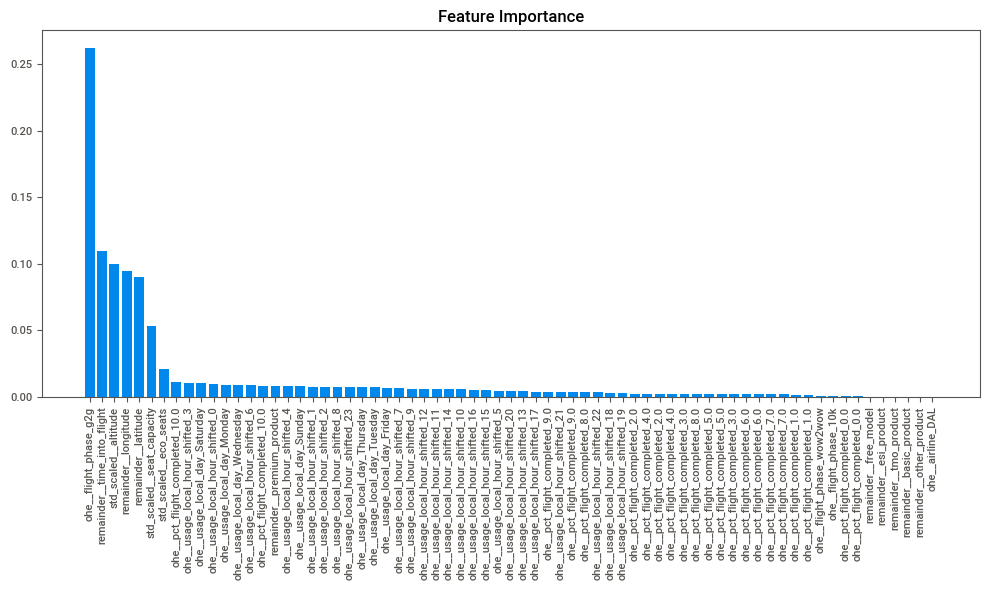

In [62]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = X_test.columns[indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_test.shape[1]), sorted_importances, align="center")
plt.xticks(range(X_test.shape[1]), sorted_features, rotation=90)
plt.tight_layout()
plt.show()

In [63]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
# Print mean absolute percentage error (MAPE), R2 score, and mean absolute error (MAE)


best_regressor = best_models[3]['model']
y_pred = best_regressor.predict(X_test)

# Calculate and print the MAPE score
mape = round(mean_absolute_percentage_error(y_test, y_pred),2)
mae = round(mean_absolute_error(y_test, y_pred),2)
mse = round(mean_squared_error(y_test, y_pred),2)
r2 = r2_score(y_test, y_pred)
print("Best Regressor's Scores: MAPE : {mape}, MAE : {mae}, MSE : {mse}, R2 : {r2}".format(mape=mape,mse=mse,mae=mae,r2=r2))

Best Regressor's Scores: MAPE : 9.02, MAE : 5.14, MSE : 46.83, R2 : 0.3950655442051011


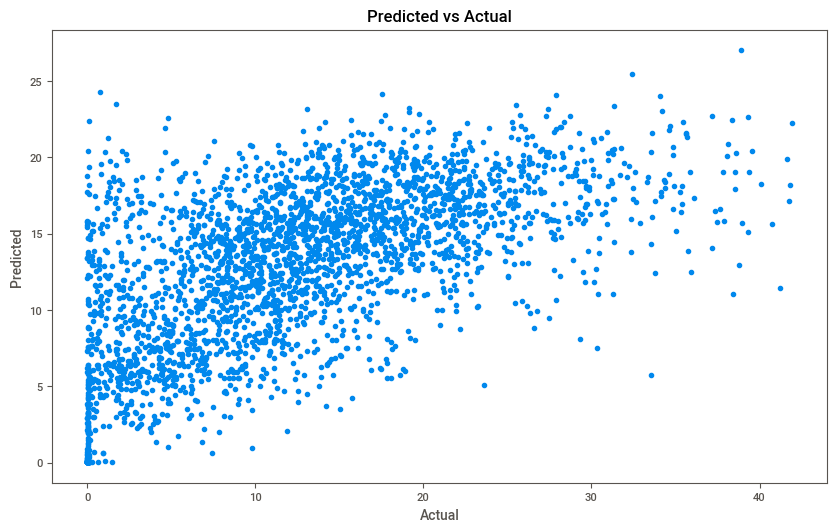

In [64]:
# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.title("Predicted vs Actual")
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
